1: Import the Weekly Economic Index (WEI) from FRED and plot it and make it a dataframe

In [19]:
!pip install fredapi 
!pip install statsmodels
!pip install pandas_datareader
!pip install matplotlib
!pip install numpy
from fredapi import Fred
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as pdr
import datetime
# Set up the FRED connection
fred = Fred(api_key='6c0ecd6565503b64631fd2b36f71293a')

In [20]:
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()
wei_data = pdr.DataReader("WEI", "fred", start, end)
print(wei_data.tail())  # View recent values
plt.show()

             WEI
DATE            
2024-12-28  2.69
2025-01-04  1.96
2025-01-11  2.27
2025-01-18  2.79
2025-01-25  2.82


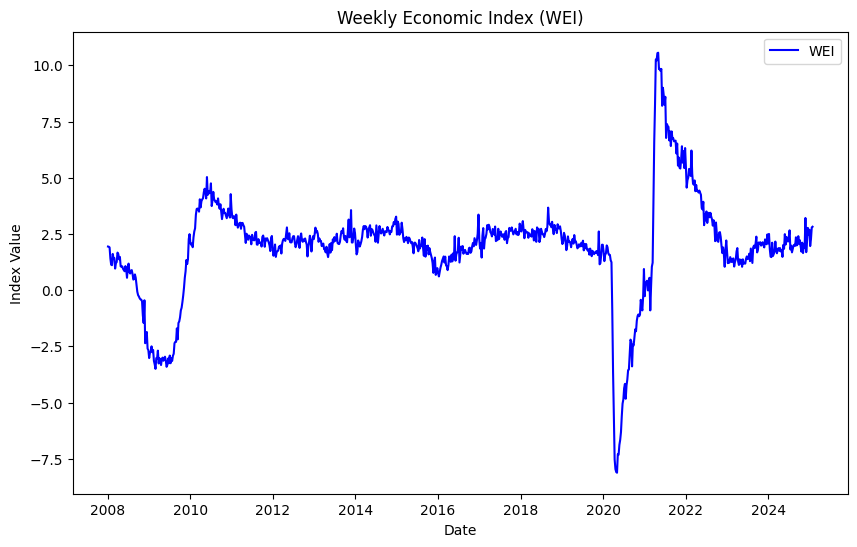

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(wei_data.index, wei_data.values, label="WEI", color='b')
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.title("Weekly Economic Index (WEI)")
plt.legend()
plt.grid(False)
plt.show()

2:  Test Stationarity (ADF), Plot Partial Autocorrelations, and Estimate AR(1)

ADF Statistic: -3.618741738773575
p-value: 0.005412670527036111


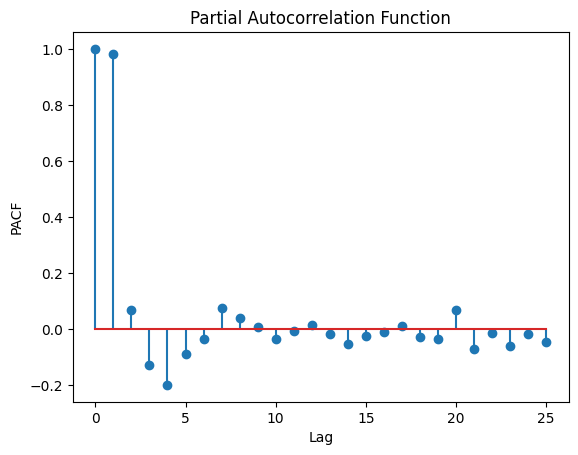

AR(1) Coefficient: 0.9820761427868694


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:465: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
/var/folders/lk/4ym49gg94jz0bf7w8jnp_wnh0000gp/T/ipykernel_54988/438806417.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'AR(1) Coefficient: {ar_model.params[1]}')


In [22]:
from statsmodels.tsa.stattools import adfuller, pacf
from statsmodels.tsa.ar_model import AutoReg

adf_result = adfuller(wei_data['WEI'].dropna())
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

pacf_values = pacf(wei_data['WEI'].dropna(), nlags=25)
plt.stem(range(len(pacf_values)), pacf_values)
plt.title('Partial Autocorrelation Function')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.grid(False)
plt.show()

ar_model = AutoReg(wei_data['WEI'].dropna(), lags=1).fit()
print(f'AR(1) Coefficient: {ar_model.params[1]}')

3. Plot a Histogram of the Data

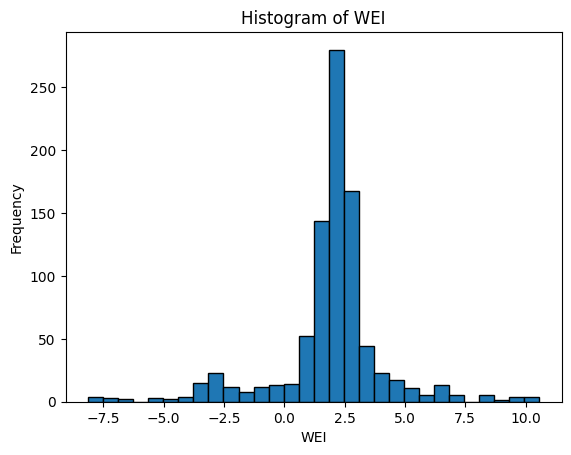

Counts: [  4.   3.   2.   0.   3.   2.   4.  15.  23.  12.   8.  12.  13.  14.
  52. 144. 280. 168.  44.  23.  17.  11.   5.  13.   5.   0.   5.   1.
   4.   4.]
Bins: [-8.12       -7.49733333 -6.87466667 -6.252      -5.62933333 -5.00666667
 -4.384      -3.76133333 -3.13866667 -2.516      -1.89333333 -1.27066667
 -0.648      -0.02533333  0.59733333  1.22        1.84266667  2.46533333
  3.088       3.71066667  4.33333333  4.956       5.57866667  6.20133333
  6.824       7.44666667  8.06933333  8.692       9.31466667  9.93733333
 10.56      ]


In [23]:
counts, bins, patches = plt.hist(wei_data['WEI'].dropna(), bins=30, edgecolor='black')
plt.title('Histogram of WEI')
plt.xlabel('WEI')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

print(f'Counts: {counts}')
print(f'Bins: {bins}')

4. Classify the Data Into States

In [24]:
def classify(x, bins, states):
    """
    Classify data into states based on bins.
    x: Data to classify
    bins: Bin edges
    states: State labels
    """
    n = len(bins)
    conditions = [(x >= bins[i]) & (x < bins[i+1]) for i in range(n-1)]
    return np.select(conditions, states, default=states[-1])

num_bins = len(bins) - 1
state_labels = [f'State {i+1}' for i in range(num_bins)]

wei_data['State'] = classify(wei_data['WEI'], bins, state_labels)


In [25]:
import numpy as np
import pandas as pd

def classify(x, bins, states):
    """
    Classify data into states based on bins.
    x: Data to classify
    bins: Bin edges
    states: Numerical state labels (1 to 5)
    """
    n = len(bins)
    conditions = [(x >= bins[i]) & (x < bins[i+1]) for i in range(n-1)]
    return np.select(conditions, states, default=states[-1])

num_bins = 5
bins = np.linspace(wei_data['WEI'].min(), wei_data['WEI'].max(), num_bins + 1)

state_labels = list(range(1, num_bins + 1)) 

wei_data['State'] = classify(wei_data['WEI'], bins, state_labels)
print(wei_data.head())

             WEI  State
DATE                   
2008-01-05  1.94      3
2008-01-12  1.93      3
2008-01-19  1.90      3
2008-01-26  1.41      3
2008-02-02  1.13      3


5. Group the Data by the Mean Within Each State

In [26]:
state_means = wei_data.groupby('State')['WEI'].mean()
print("Mean Growth Rate by State:")
print(state_means)

Mean Growth Rate by State:
State
1   -6.575000
2   -2.512432
3    1.988927
4    4.356460
5    8.835263
Name: WEI, dtype: float64


6. Estimate the Markov Transition Matrix

In [27]:
transition_matrix = pd.crosstab(wei_data['State'].shift(1), wei_data['State'], normalize=0)
print(transition_matrix)

State         1         2         3         4         5
State                                                  
1.0    0.857143  0.142857  0.000000  0.000000  0.000000
2.0    0.027027  0.905405  0.067568  0.000000  0.000000
3.0    0.000000  0.007463  0.974627  0.017910  0.000000
4.0    0.000000  0.000000  0.106195  0.858407  0.035398
5.0    0.000000  0.000000  0.000000  0.210526  0.789474


7. Check Aperiodicity, Irreducibility, and Communication Classes

In [28]:
import networkx as nx
import numpy as np

import quantecon as qe
from quantecon import MarkovChain
mc = qe.MarkovChain(transition_matrix)

mc.is_irreducible
mc.period
mc.stationary_distributions 

def is_aperiodic(transition_matrix):
    n = transition_matrix.shape[0]
    gcd_values = np.zeros(n, dtype=int)

    for i in range(n):
        state_visits = []
        for j in range(n):
            if transition_matrix[i, j] > 0:
                state_visits.append(j)
        if len(state_visits) > 1:
            gcd_values[i] = np.gcd.reduce(state_visits)

    return np.all(gcd_values == 1)


is_chain_aperiodic = is_aperiodic(transition_matrix.values)
print(f'Is the Markov chain aperiodic? {is_chain_aperiodic}')


G = nx.DiGraph(transition_matrix.values)

communication_classes = list(nx.strongly_connected_components(G))
print(f'Communication Classes: {communication_classes}')

is_irreducible = len(communication_classes) == 1
print(f'Is the Markov chain irreducible? {is_irreducible}')

Is the Markov chain aperiodic? True
Communication Classes: [{0, 1, 2, 3, 4}]
Is the Markov chain irreducible? True


In [29]:
mc.is_irreducible

True

In [30]:
mc.period

1

8. Find the Ergodic Distribution of States and Check Uniqueness

In [31]:
import numpy.linalg as la

eigvals, eigvecs = la.eig(transition_matrix.T)
stationary_dist = np.real(eigvecs[:, np.isclose(eigvals, 1)])
stationary_dist /= stationary_dist.sum()
print(f'Stationary Distribution: {stationary_dist.flatten()}')

Stationary Distribution: [0.01573034 0.08314607 0.75280899 0.12696629 0.02134831]


In [32]:
mc.stationary_distributions

array([[0.01573034, 0.08314607, 0.75280899, 0.12696629, 0.02134831]])

### Is it unique?
Yes, the ergodotic distribution is unique becuase it is aperiodic and irreducible

## 9. Two Year Simulation
Starting from the Current State

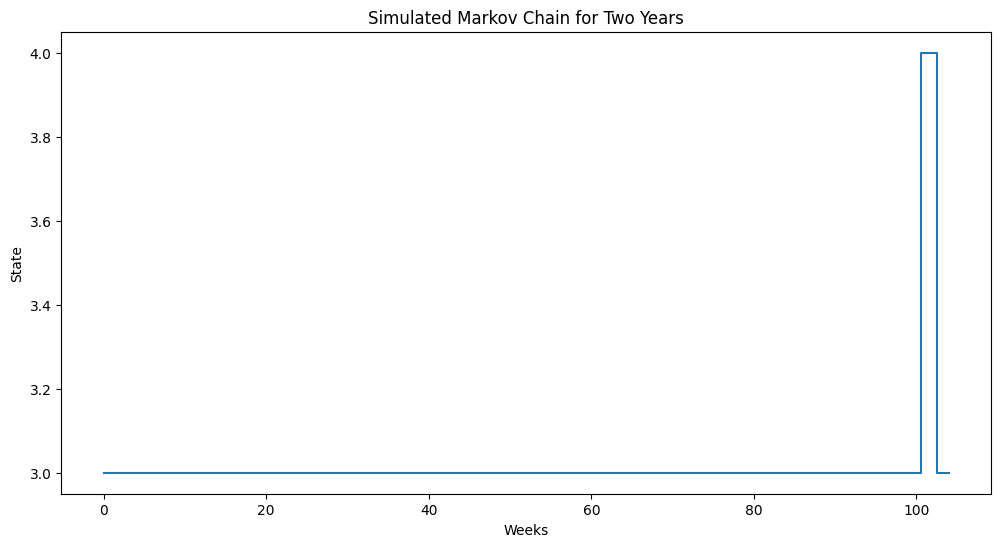

In [33]:
def simulate_markov_chain(start_state, transition_matrix, steps, states):
    current_state = start_state
    state_sequence = [current_state]

    for _ in range(steps):
        probs = transition_matrix.loc[current_state].values
        current_state = np.random.choice(states, p=probs)
        state_sequence.append(current_state)
    
    return state_sequence

# Starting from the current state
current_state = wei_data['State'].iloc[-1]
states = transition_matrix.columns.tolist()
simulated_states = simulate_markov_chain(current_state, transition_matrix, 104, states)

plt.figure(figsize=(12, 6))
plt.step(range(len(simulated_states)), simulated_states, where='mid')
plt.xlabel('Weeks')
plt.ylabel('State')
plt.grid(False)
plt.title('Simulated Markov Chain for Two Years')
plt.show()

## 10. Mean Hitting Time
Between Occurrences of the Worst State

In [34]:
def mean_recurrence_time(target_state=1, simulations=1000):
    recurrence_times = []

    for _ in range(simulations):
        current_state = target_state  # Start from State 1
        steps = 0

        while True:
            probs = transition_matrix.loc[current_state].values
            next_state = np.random.choice(states, p=probs)
            steps += 1

            if next_state == target_state:  # Return to State 1
                recurrence_times.append(steps)
                break
            else:
                current_state = next_state

    return np.mean(recurrence_times)

mean_recurrence = mean_recurrence_time()
print(f'Mean Hitting Time Between Occurrences of State 1: {mean_recurrence} weeks')

Mean Hitting Time Between Occurrences of State 1: 78.605 weeks


## 11. Probability of “Covid” State in Next Two Years

In [35]:
def covid_state_probability(simulations=1000):
    occurrences = 0

    for _ in range(simulations):
        sim = simulate_markov_chain(current_state, transition_matrix, 104, states)
        if 1 in sim:
            occurrences += 1

    return occurrences / simulations

covid_prob = covid_state_probability(1000)
print(f'Probability of Reaching State 1 (Covid state) in the Next 2 Years: {covid_prob:.4f}')

Probability of Reaching State 1 (Covid state) in the Next 2 Years: 0.1370


## 12. Markov Chain Simulation
Simulate a Sample the Same Size as the Original, Repeat Stationarity Tests

Simulated ADF Statistic: -6.204486973156754
Simulated p-value: 5.701483756568018e-08


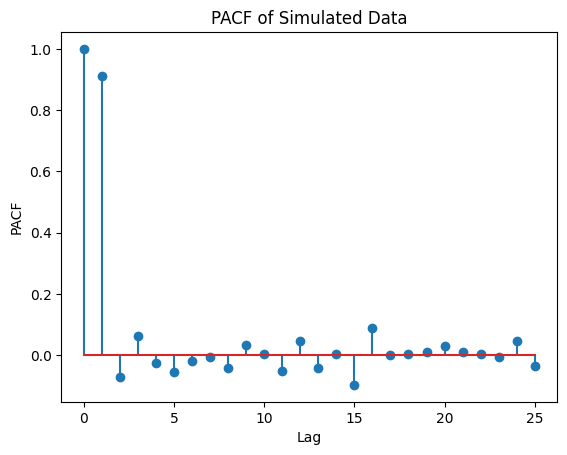

AR(1) Coefficient (Simulated Data): 0.9098


/var/folders/lk/4ym49gg94jz0bf7w8jnp_wnh0000gp/T/ipykernel_54988/1296399597.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"AR(1) Coefficient (Simulated Data): {ar1_model_sim.params[1]:.4f}")


In [36]:
sim_length = len(wei_data)

simulated_full_data = simulate_markov_chain(current_state, transition_matrix, sim_length, states)
simulated_df = pd.DataFrame({'State': simulated_full_data})

simulated_adf_result = adfuller(simulated_df['State'].astype('category').cat.codes)
print(f'Simulated ADF Statistic: {simulated_adf_result[0]}')
print(f'Simulated p-value: {simulated_adf_result[1]}')

sim_pacf_values = pacf(simulated_df['State'].astype('category').cat.codes, nlags=25)
plt.stem(range(len(sim_pacf_values)), sim_pacf_values)
plt.title('PACF of Simulated Data')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.grid(False)
plt.show()

simulated_df['State'] = simulated_df['State'].astype('category').cat.codes
simulated_df['State'] = pd.to_numeric(simulated_df['State'])

ar1_model_sim = AutoReg(simulated_df['State'], lags=1).fit()
print(f"AR(1) Coefficient (Simulated Data): {ar1_model_sim.params[1]:.4f}")

### Does the Markov model seem to simulate the data well?
Yes it does, looks very similar to the autocorrelation plot